<div>
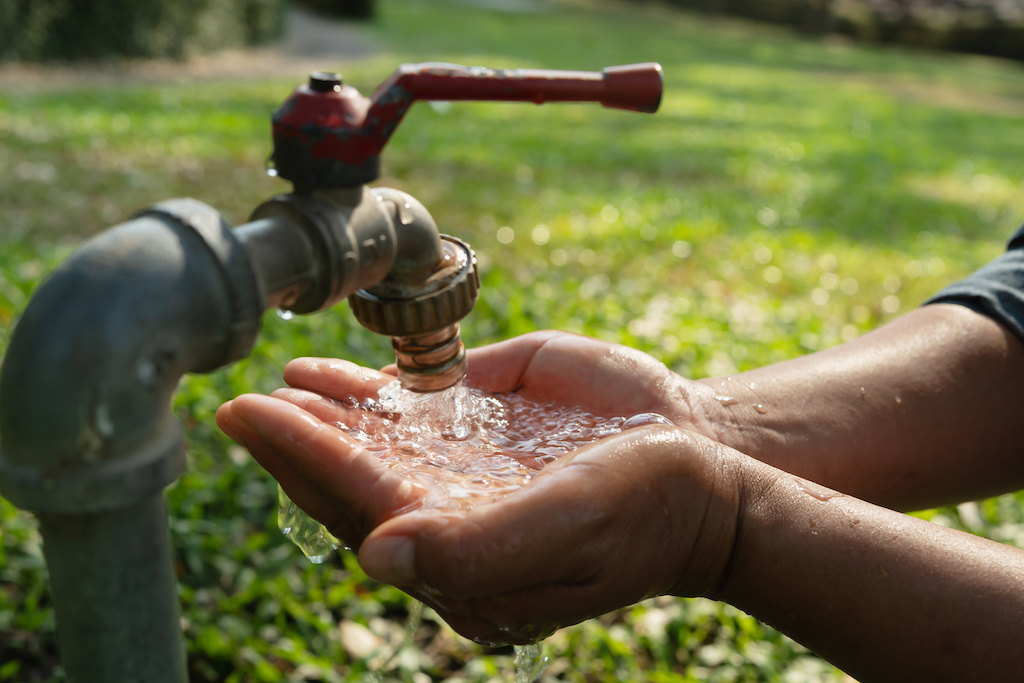
</div>
Photo by <a href="https://stock.adobe.com/contributor/203603884/lovelyday12?load_type=author&prev_url=detail" >lovelyday12</a> on Adobe Stock

# Phase 3 Project: *Tanzanian Water Pump Conditions Classification Model*

### By Ryan Posternak

Flatiron School, Full-time Live NYC<br>
Project Presentation Date: July 15th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify which water pumps in Tanzania are functional, functional but in need of repair, or non-functional based on a variety of conditions and information on the pump 

<br>

# Overview and Business Understanding

<br>

# Data Understanding

<br>

# Data Cleaning & EDA

### Description of columns

**amount_tsh** - Total static head (amount water available to waterpoint)<br>
**date_recorded** - The date the row was entered<br>
**funder** - Who funded the well<br>
**gps_height** - Altitude of the well<br>
**installer** - Organization that installed the well<br>
**longitude** - GPS coordinate<br>
**latitude** - GPS coordinate<br>
**wpt_name** - Name of the waterpoint if there is one<br>
**num_private** -<br>
**basin** - Geographic water basin<br>
**subvillage** - Geographic location<br>
**region** - Geographic location<br>
**region_code** - Geographic location (coded)<br>
**district_code** - Geographic location (coded)<br>
**lga** - Geographic location<br>
**ward** - Geographic location<br>
**population** - Population around the well<br>
**public_meeting** - True/False<br>
**recorded_by** - Group entering this row of data<br>
**scheme_management** - Who operates the waterpoint<br>
**scheme_name** - Who operates the waterpoint<br>
**permit** - If the waterpoint is permitted<br>
**construction_year** - Year the waterpoint was constructed<br>
**extraction_type** - The kind of extraction the waterpoint uses<br>
**extraction_type_group** - The kind of extraction the waterpoint uses<br>
**extraction_type_class** - The kind of extraction the waterpoint uses<br>
**management** - How the waterpoint is managed<br>
**management_group** - How the waterpoint is managed<br>
**payment** - What the water costs<br>
**payment_type** - What the water costs<br>
**water_quality** - The quality of the water<br>
**quality_group** - The quality of the waterv<br>
**quantity** - The quantity of water<br>
**quantity_group** - The quantity of water<br>
**source** - The source of the water<br>
**source_type** - The source of the water<br>
**source_class** - The source of the water<br>
**waterpoint_type** - The kind of waterpoint<br>
**waterpoint_type_group** - The kind of waterpoint<br>
<br>

### Description of labels

**functional** - the waterpoint is operational and there are no repairs needed<br>
**functional needs repair** - the waterpoint is operational, but needs repairs<br>
**non functional** - the waterpoint is not operational

In [27]:
import numpy as np
import pandas as pd

In [14]:
# Load up the data

submission_format_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Submission_format.csv')

X_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')

y_train_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

X_test_df = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv')

In [35]:
# Preview features

print(X_train_df.shape)
X_train_df.head()

(59400, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [29]:
# Preview target variables

y_train_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [33]:
# Preview distribution of target variables

print(y_train_df['status_group'].value_counts(), '\n')
print(y_train_df['status_group'].value_counts(normalize=True))

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64 

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


In [36]:
# Preview dataframe info

X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

> **Remarks:**
> - 7 int features, 3 float features, 30 object features
> - Some features with a lot of missing values: scheme_name, funder, installer, scheme_management


In [37]:
X_train_df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
